# Protonemata branching - aberrant vs normal

In [1]:
library(splines)
library(scales)
library(ggplot2)
library(sleuth)

In [2]:
#https://stackoverflow.com/questions/41849951/using-ggplot-geo-geom-histogram-with-y-log-scale-with-zero-bins
mylog10_trans <- function (base = 10) 
{
  trans <- function(x) log(x + 1, base)
  inv <- function(x) base^x
  trans_new(paste0("log-", format(base)), trans, inv, log_breaks(base = base), 
            domain = c(1e-100, Inf))
}

In [3]:
d=read.delim("../kallisto/sample_descriptions/our_data.txt",sep="\t",stringsAsFactors=FALSE)
names(d)[1:2]=c("sample","sample_alias")
d$batch=as.numeric(gsub("^[^-]+-[^-]+-[^-]+-(\\d+$)$","\\1",gsub("([A-z]+)(\\d+)","\\1-\\2",d$sample,perl=TRUE),perl=TRUE))
d$batch[is.na(d$batch)]=1
table(d$batch)
d$harvest=sprintf("%id_b%i",d$Time,d$batch)
table(d$harvest)
head(d)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


 1  2  3 
24 25 25 


12d_b1 12d_b2 12d_b3 14d_b1 14d_b2 14d_b3  3d_b1  3d_b2  3d_b3  5d_b1  5d_b2 
     5      5      5      5      5      5      4      5      5      5      5 
 5d_b3  9d_b1  9d_b2  9d_b3 
     5      5      5      5 

sample,sample_alias,Group,GT,Time,elongation_caulonema,protonemata_branching,number_buds_per_filament,percents_filaments_with_buds,gametophore_formation,colony_size,rhizoid_formation,development_of_phyllids,batch,harvest
1-W3,1.W3,1,WT,3,normal,normal,absent,absent,absent,normal,absent,absent,1,3d_b1
2-W3-2,2.W3.2,1,WT,3,normal,normal,absent,absent,absent,normal,absent,absent,2,3d_b2
3-W3-3,3.W3.3,1,WT,3,normal,normal,absent,absent,absent,normal,absent,absent,3,3d_b3
4-D3,4.D3,2,deltaDEK,3,normal,normal,absent,absent,absent,normal,absent,absent,1,3d_b1
5-D3-2,5.D3.2,2,deltaDEK,3,normal,normal,absent,absent,absent,normal,absent,absent,2,3d_b2
6-D3-3,6.D3.3,2,deltaDEK,3,normal,normal,absent,absent,absent,normal,absent,absent,3,3d_b3


In [4]:
d$path=sprintf("../kallisto/kallisto/%s/abundance.h5",d$sample)

In [5]:
#outlier replicates
exclude=d$sample[grep("5-3$",d$sample,perl=TRUE)]

In [6]:
d=droplevels(subset(d,! sample %in% exclude ))

In [7]:
variable ="protonemata_branching"
variable2 ="protonemata_branching"
normal="normal"
alt="aberrant"
table(d[,variable])


aberrant   normal 
       9       60 

In [8]:
#d=droplevels(subset(d,Time >5 ))
if (!is.null(alt)) {
    d=droplevels(d[d[,variable] %in% c(normal,alt),])
    d[,variable]=factor(d[,variable],levels=c(normal,alt))
}
table(d[,variable])


  normal aberrant 
      60        9 

In [9]:
table(file.exists(sprintf("../kallisto/kallisto/%s/abundance.h5",d$sample)))


TRUE 
  69 

In [10]:
m=read.delim("../analysis/cosmoss_V3.3.mRNA_ncRNA.tx2gene.full.tsv",stringsAsFactors=FALSE)
names(m)[1]="target_id"
m$class=ifelse(is.na(m$class),m$TYPE,m$class)
m$gene=as.character(paste(m$GENEID,m$class,sep="."))
m=m[,c("target_id","gene","class","TYPE")]
nrow(m)
head(m)

[1] 93962

target_id,gene,class,TYPE
Pp3c1_20V3.1,Pp3c1_20.mRNA,mRNA,mRNA
Pp3c1_20V3.2,Pp3c1_20.mRNA,mRNA,mRNA
Pp3c1_40V3.2,Pp3c1_40.mRNA,mRNA,mRNA
Pp3c1_40V3.1,Pp3c1_40.mRNA,mRNA,mRNA
Pp3c1_50V3.2,Pp3c1_50.mRNA,mRNA,mRNA
Pp3c1_50V3.1,Pp3c1_50.mRNA,mRNA,mRNA


In [11]:
so=sleuth_prep(d, target_mapping = m,aggregation_column = 'gene', 
               gene_mode = TRUE,extra_bootstrap_summary = TRUE,read_bootstrap_tpm=TRUE)

'gene_mode' is TRUE. Sleuth will do counts aggregation at the gene level for downstream normalization, transformation, and modeling steps, as well as for plotting and results.
reading in kallisto results
dropping unused factor levels
.....................................................................
normalizing est_counts
45228 targets passed the filter
normalizing tpm
merging in metadata
aggregating by column: gene
21667 genes passed the filter
Warning message in sleuth_prep(d, target_mapping = m, aggregation_column = "gene", :
“2 target_ids are missing annotations for the aggregation_column: gene.
These target_ids will be dropped from the gene-level analysis.
If you did not expect this, check your 'target_mapping' table for missing values.”summarizing bootstraps



In [12]:
options(repr.plot.width=10, repr.plot.height=5)

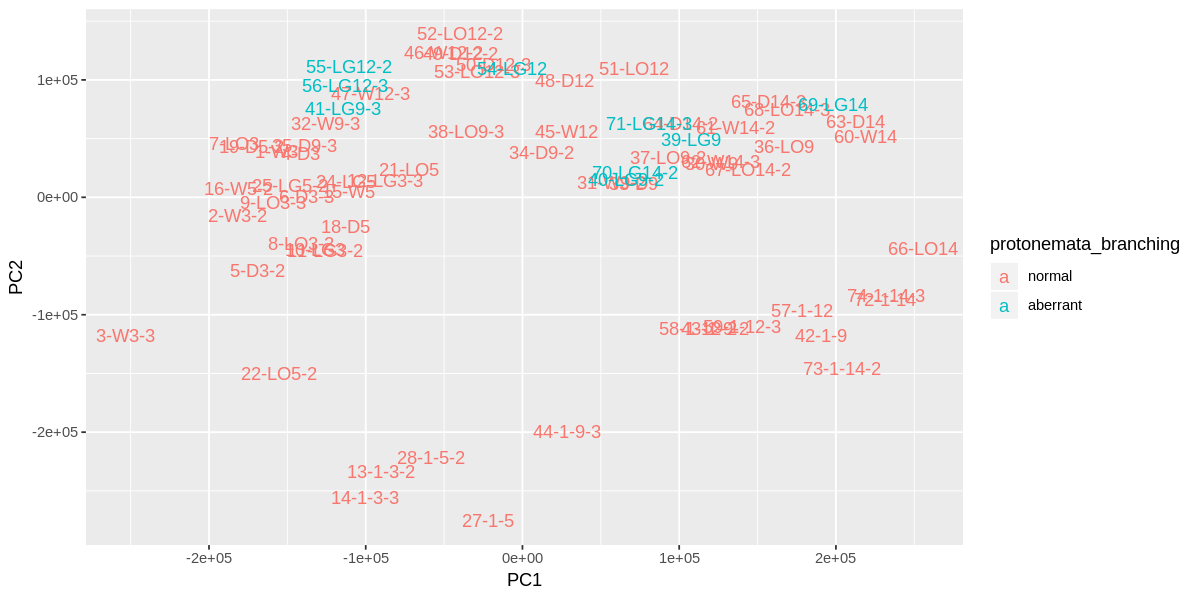

In [13]:
plot_pca(so, color_by = variable,text_labels = TRUE,units='scaled_reads_per_base')

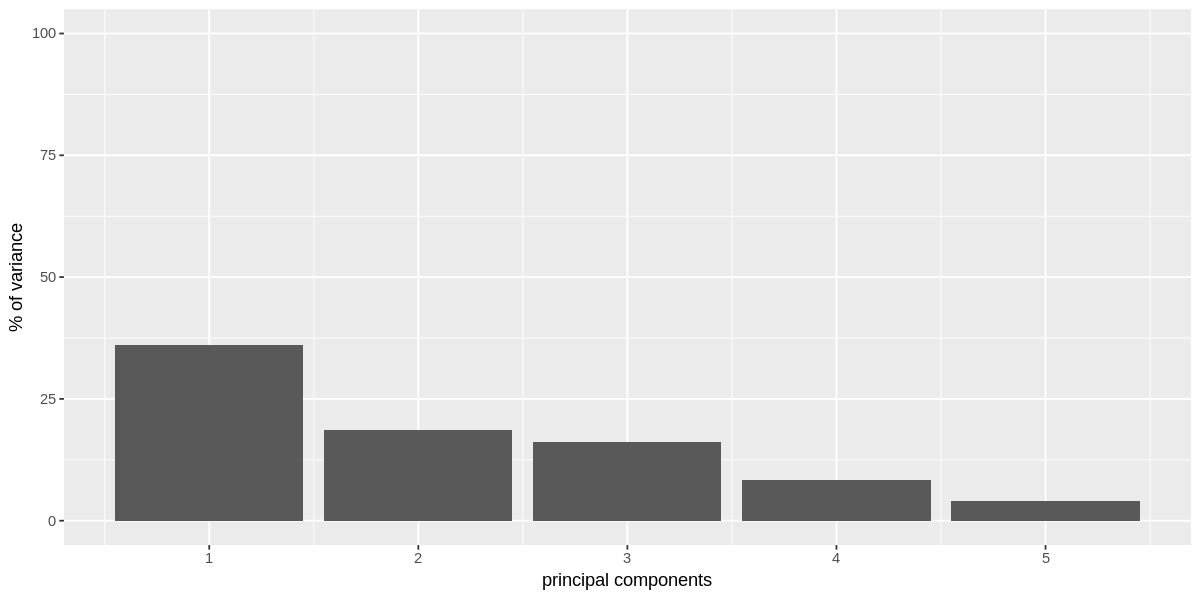

In [14]:
plot_pc_variance(so,units='scaled_reads_per_base')

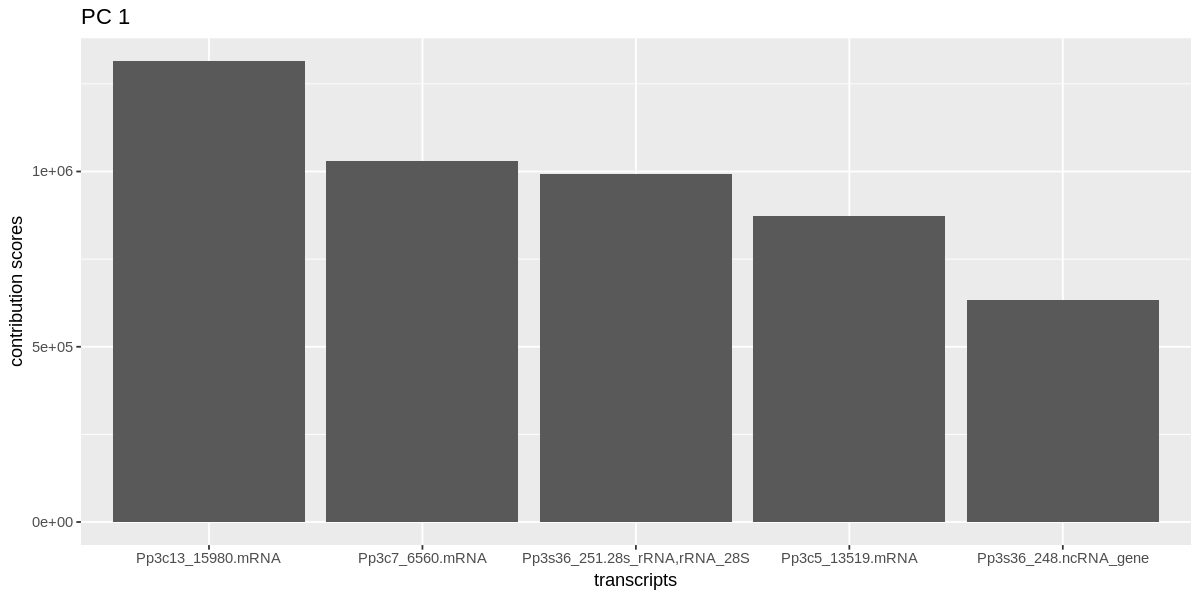

In [15]:
plot_loadings(so, pc_input = 1,units='scaled_reads_per_base')

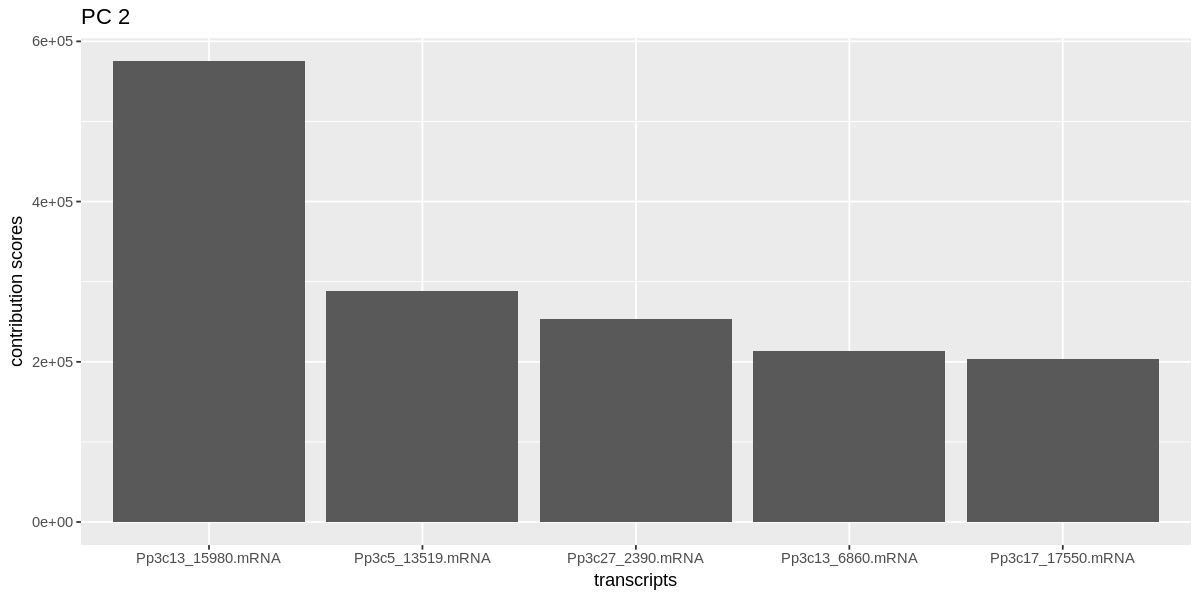

In [16]:
plot_loadings(so, pc_input = 2,units='scaled_reads_per_base')

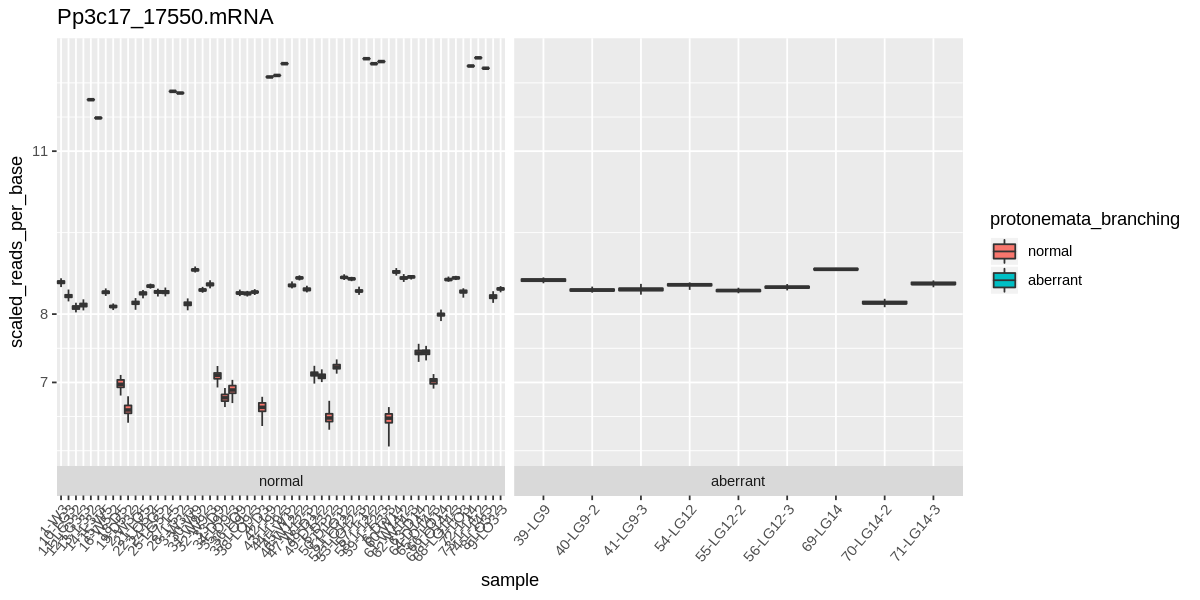

In [17]:
plot_bootstrap(so, 'Pp3c17_17550.mRNA', color_by = variable,units='scaled_reads_per_base') + scale_y_continuous(trans = "mylog10")

In [18]:
full_design <- model.matrix(as.formula(paste("~ ",variable,"+ factor(batch)",sep="")),data=d)
reduced_design <- model.matrix(formula(~  factor(batch)) ,data=d)

In [19]:
dim(full_design)
head(full_design)

[1] 69  4

(Intercept),protonemata_branchingaberrant,factor(batch)2,factor(batch)3
1,0,0,0
1,0,1,0
1,0,0,1
1,0,0,0
1,0,1,0
1,0,0,1


In [20]:
dim(reduced_design)
dim(full_design)

[1] 69  3

[1] 69  4

In [21]:
so= sleuth_fit(so,reduced_design,fit_name="reduced")

fitting measurement error models
shrinkage estimation
computing variance of betas


In [22]:
so= sleuth_fit(so, full_design, fit_name = "full")

fitting measurement error models
shrinkage estimation
computing variance of betas


In [23]:
so = sleuth_lrt(so, "reduced", "full")

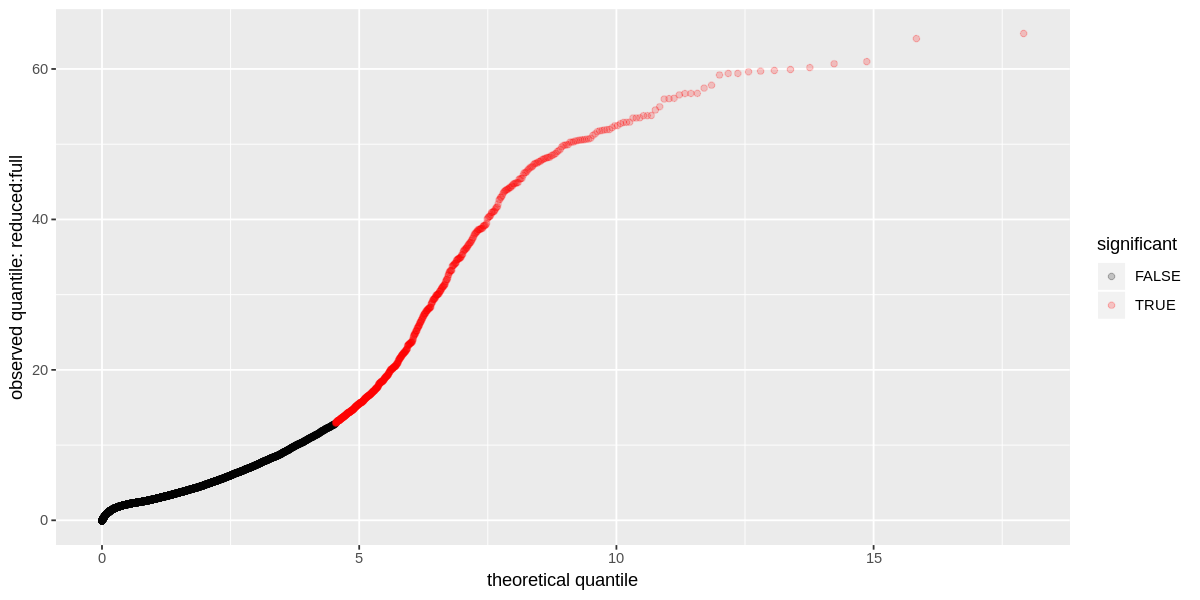

In [24]:
plot_qq(so, test = 'reduced:full', test_type = 'lrt', sig_level = 0.01)

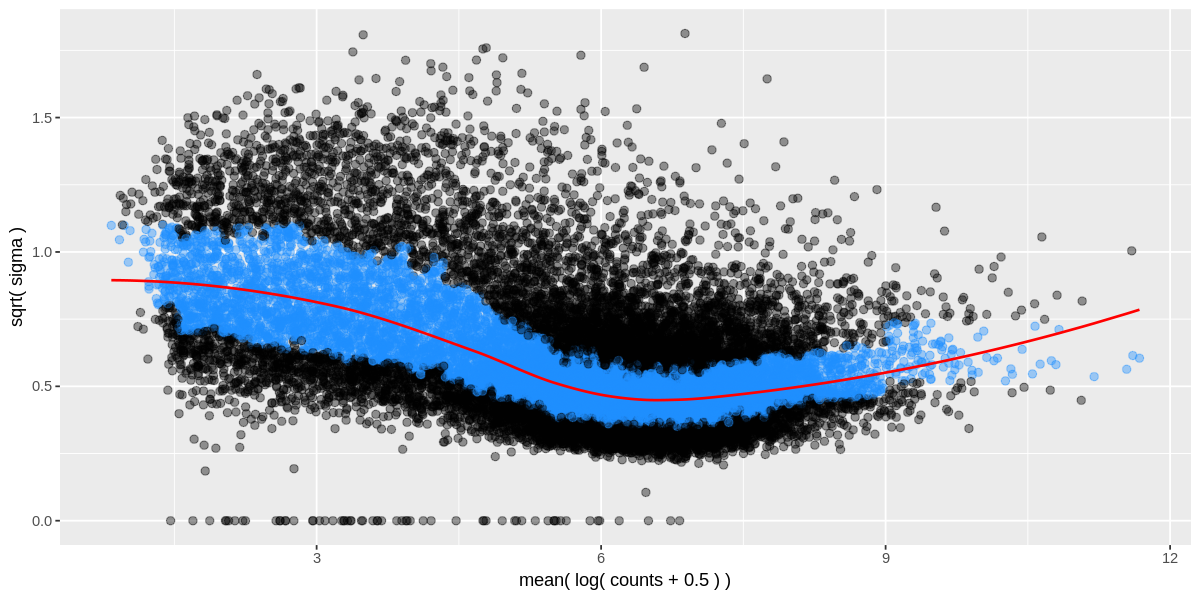

In [25]:
plot_mean_var(so,which_model="full")

In [26]:
lrt_results= sleuth_results(so, 'reduced:full', test_type = 'lrt',show_all=TRUE)
table(lrt_results$qval<0.01)


FALSE  TRUE 
20951   716 

In [27]:
models(so)

[  reduced  ]
formula:  structure(c(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,  1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,  1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,  1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,  0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,  0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,  0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,  1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,  1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,  1), .Dim = c(69L, 3L), .Dimnames = list(c("1", "2", "3", "4",  "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15",  "16", "18", "19", "21", "22", "24", "25", "27", "28", "30", "31",  "32", "33", "34", "35", "36", "37", "38", "39", "40", "41", "42",  "43", "44", "45", "46", "47", "48", "49", "50", "51", "52", "53",  "54", "55"

In [28]:
so=sleuth_wt(so, which_beta = colnames(full_design)[2], which_model = 'full')
tt=sleuth_results(so,colnames(full_design)[2],"wt")
tt.sig= dplyr::filter(tt, qval < 0.01)
nrow(tt.sig)
table(tt.sig$b>0)

[1] 756


FALSE  TRUE 
  154   602 

In [29]:
o=na.omit(merge(lrt_results,tt,by="target_id",suffixes=c(".lrt",".wt")))
o=o[order(-o$b,-o$test_stat),]
table(o$b>0)
head(o[o$b>0,])


FALSE  TRUE 
10801 10866 

,target_id,class.lrt,TYPE.lrt,pval.lrt,qval.lrt,test_stat,rss,degrees_free,mean_obs.lrt,var_obs.lrt,⋯,pval.wt,qval.wt,b,se_b,mean_obs.wt,var_obs.wt,tech_var.wt,sigma_sq.wt,smooth_sigma_sq.wt,final_sigma_sq.wt
21723,Pp3c24_12780.mRNA,mRNA,mRNA,2.333226e-08,2.340463e-06,31.19536,691.1041,1,2.469170,10.225338,⋯,1.047468e-09,1.065516e-07,5.675199,0.9300550,2.469170,10.225338,0.10577531,6.654217,0.5154340,6.654217
21906,Pp3c24_1600.mRNA,mRNA,mRNA,6.289652e-06,3.663384e-04,20.39797,590.4142,1,2.161712,8.720456,⋯,2.184770e-06,1.304061e-04,4.402146,0.9295983,2.161712,8.720456,0.76482547,5.988530,0.5545398,5.988530
30015,Pp3c6_15620.mRNA,mRNA,mRNA,1.801695e-05,9.057383e-04,18.38821,482.6436,1,4.216561,7.113257,⋯,8.093740e-06,4.155618e-04,3.805850,0.8528155,4.216561,7.113257,0.10276033,5.581044,0.2241162,5.581044
13032,Pp3c18_15100.mRNA,mRNA,mRNA,1.549072e-08,1.598274e-06,31.99077,287.5978,1,1.864669,4.241205,⋯,5.705112e-10,6.059444e-08,3.697464,0.5965220,1.864669,4.241205,0.16542914,2.615449,0.5865398,2.615449
32612,Pp3c7_7280.mRNA,mRNA,mRNA,1.105462e-03,2.390425e-02,10.64203,735.0998,1,4.789060,10.827072,⋯,9.625246e-04,2.147788e-02,3.675124,1.1132498,4.789060,10.827072,0.10044547,9.584880,0.1425415,9.584880
78,Pp3c1_11310.mRNA,mRNA,mRNA,3.728311e-04,1.091281e-02,12.66366,570.8818,1,3.446937,8.397461,⋯,2.867615e-04,8.552559e-03,3.506508,0.9667860,3.446937,8.397461,0.06645443,7.238032,0.3630028,7.238032


In [30]:
m1=read.delim("../analysis//cosmoss_V3.3.mRNA_ncRNA.tx2gene.full.gene_wise.tsv",sep="\t",stringsAsFactors=FALSE)
names(m1)[1]="target_id"
head(m1)

target_id,spectype,TXNAME,GENEID,TYPE,Alias,support,origin,isoform,longest_transcript,has_evidence,class,has_protein_homology,has_proteomics_support,encoded_by,is_filtered
Pp3c10_10000.tRNA,tRNA,Pp3c10_10000V3.1,Pp3c10_10000,ncRNA,"tRNA,Pp3c10_10000N1.1,Pp3c10_10000V1.1,N1.Chr10.ncRNA.54,tRNA.717",supported_by_sequence_similarity,RFAM11.Infernal1.1,major,true,false,tRNA,false,false,ncRNA_gene,false
Pp3c10_10040.mRNA,mRNA,"Pp3c10_10040V3.2,Pp3c10_10040V3.3,Pp3c10_10040V3.5,Pp3c10_10040V3.6,Pp3c10_10040V3.4,Pp3c10_10040V3.1",Pp3c10_10040,mRNA,"PAC4GC:5701563,Pp3c10_10040J4.1,Pp1s58_283V6.2,PAC4GC:5701564,P2.evm.model.Chr10.357,Pp3c10_10040J5.3,Pp3c10_10040J5.4,Pp3c10_10040V1.1,P2.Chr10.mRNA.3452,Phpatv32029367m,PAC4GC:5701565,Phpatv32029366m,PAC4GC:5701561,Pp3c10_10040J5.2,Pp1s58_283V6.1,Pp3c10_10040J5.1,Phpatv32029364m,Pp3c10_10040P2.1,Phpatv32029365m,Phpatv32029363m,P2.EVM%20prediction%20Chr10.357,Pp3c10_10040P2.2,PAC4GC:5701562",supported_by_EST_or_cDNA,NA,"alternative,major","true,false",true,NA,true,false,protein_coding_gene,false
Pp3c10_10090.mRNA,mRNA,"Pp3c10_10090V3.2,Pp3c10_10090V3.1",Pp3c10_10090,mRNA,"Phpatv32029368m,Pp3c10_10090V1.1,J3.Chr10.mRNA.912,J3.Phypav3.0.4_pg25522.valid.m1,J3.7022241,Pp3c10_10090J4.1,Pp3c10_10090J3.1,PAC4GC:5700224,pred.234120000946",supported_by_EST_or_cDNA,NA,"major,alternative","false,true",true,NA,false,false,protein_coding_gene,false
Pp3c10_10095.C_D_box_snoRNA,C_D_box_snoRNA,Pp3c10_10095V3.1,Pp3c10_10095,ncRNA,"Chr10.snoRNA.21,snoR64.1,Chr10.snoRNA.22,Pp3c10_10095V1.1,Chr10.snoRNA.32,Chr10.snoRNA.23,snoR64,N1.Chr10.ncRNA.55,Pp3c10_10095N1.1,Chr10.snoRNA.33,snR72%2FZ2,snR58",supported_by_sequence_similarity,"RFAM11.Infernal1.1,snoscan-0.9b",major,true,true,C_D_box_snoRNA,false,false,ncRNA_gene,false
Pp3c10_100.ncRNA,ncRNA,Pp3c10_100V3.1,Pp3c10_100,ncRNA,"Pp3c10_100V1.1,Pp3c10_100P0.1,asmbl_110854",supported_by_EST_or_cDNA,NA,major,true,true,NA,false,false,ncRNA_gene,false
Pp3c10_10100.mRNA,mRNA,"Pp3c10_10100V3.1,Pp3c10_10100V3.4,Pp3c10_10100V3.2,Pp3c10_10100V3.5,Pp3c10_10100V3.3",Pp3c10_10100,mRNA,"Pp3c10_10100J5.3,Phpatv32029369m,PAC4GC:5701591,PAC4GC:5701593,Pp1s58_289V6.1_29440,PAC4GC:5701592,Phpatv32029370m,Pp3c10_10100V1.1,Phpatv32029372m,Pp3c10_10100J5.1,Pp3c10_10100J5.2,C1.Pp1s58_289V6.1,Phpatv32029371m,C1.560145,PAC4GC:5701590,Pp1s58_289V6.1,C1.Chr10.mRNA.576,Pp3c10_10100J4.1,Pp3c10_10100C1.1",supported_by_EST_or_cDNA,NA,"alternative,major","true,false",true,NA,true,false,protein_coding_gene,false


In [31]:
m2=read.delim("../analysis//cosmoss.genonaut.V3.3.gene_and_protein_names.tsv",sep="\t",col.names=c("GENEID","name"),stringsAsFactors=FALSE)
head(m2)

GENEID,name
Pp3c10_13310,XTH28
Pp3c10_13800,"chr1545,CHR1545"
Pp3c10_13960,"CHLH1,CHLH2,chlh2,chlh1"
Pp3c10_13970,"chlh1,chlh2,CHLH2,CHLH1"
Pp3c10_14020,"RABA53,raba53"
Pp3c10_14800,"PPR_20,ppr_20"


In [32]:
m3=read.delim("../analysis//Ppatens_318_v3.3.defline.txt",sep="\t",col.names=c("GENEID","source","defline"),stringsAsFactors=FALSE)
m3$GENEID=gsub("V3\\.\\d+","",m3$GENEID,perl=TRUE)
head(m3)

GENEID,source,defline
Pp3c10_10220,pdef,"K00615 - transketolase (E2.2.1.1, tktA, tktB) (1 of 4)"
Pp3c10_10230,pdef,K14763 - H/ACA ribonucleoprotein complex non-core subunit NAF1 (NAF1) (1 of 1)
Pp3c10_10240,pdef,PTHR10641:SF599 - MYB TRANSCRIPTION FACTOR-RELATED (1 of 3)
Pp3c10_10270,pdef,2.4.1.12 - Cellulose synthase (UDP-forming) / UDP-glucose-cellulose glucosyltransferase (1 of 17)
Pp3c10_10460,pdef,"K03320 - ammonium transporter, Amt family (amt, AMT, MEP) (1 of 12)"
Pp3c10_10490,pdef,"PTHR11177:SF167 - RHODANESE-LIKE DOMAIN-CONTAINING PROTEIN 4, CHLOROPLASTIC (1 of 3)"


In [33]:
m4=read.delim("../analysis//Physcomitrella_patens.TAP_annotation.6.tsv",sep="\t")
names(m4)[2]="GENEID"
head(m4)

superfamily,GENEID,inferred_by_rule,TAP_class
BSD domain containing,Pp3c11_12590V3,True,PT
BSD domain containing,Pp3c1_21290V3,True,PT
BSD domain containing,Pp3c20_12230V3,True,PT
BSD domain containing,Pp3c23_10600V3,True,PT
BSD domain containing,Pp3c24_7080V3,True,PT
BSD domain containing,Pp3c26_14480V3,True,PT


In [34]:
O=merge(o,m1,by="target_id")
nrow(o)
nrow(O)
O=merge(O,m2,by="GENEID",all.x=TRUE)
nrow(O)
O=merge(O,m3,by="GENEID",all.x=TRUE)
nrow(O)
O=merge(O,m4,by="GENEID",all.x=TRUE)
nrow(O)
O=O[order(-O$test_stat),]
head(O)

[1] 21667

[1] 21667

[1] 21667

[1] 21667

[1] 21667

,GENEID,target_id,class.lrt,TYPE.lrt,pval.lrt,qval.lrt,test_stat,rss,degrees_free,mean_obs.lrt,⋯,has_protein_homology,has_proteomics_support,encoded_by,is_filtered,name,source,defline,superfamily,inferred_by_rule,TAP_class
13244,Pp3c24_15470,Pp3c24_15470.mRNA,mRNA,mRNA,8.638331e-16,1.320366e-11,64.71888,7.229167,1,7.349363,⋯,true,false,protein_coding_gene,false,NA,pdef,K11968 - ariadne-1 (ARIH1) (1 of 6),NA,NA,NA
13360,Pp3c24_19130,Pp3c24_19130.mRNA,mRNA,mRNA,1.218781e-15,1.320366e-11,64.04065,7.128323,1,6.594763,⋯,true,"true,false",protein_coding_gene,false,NA,pdef,K03189 - urease accessory protein (ureG) (1 of 1),NA,NA,NA
13577,Pp3c24_6340,Pp3c24_6340.mRNA,mRNA,mRNA,5.762923e-15,2.526702e-11,60.98097,7.032815,1,6.746651,⋯,true,true,protein_coding_gene,false,NA,pdef,PTHR31521:SF2 - EXPRESSED PROTEIN (1 of 4),NA,NA,NA
13110,Pp3c24_11680,Pp3c24_11680.mRNA,mRNA,mRNA,6.639750e-15,2.526702e-11,60.70215,5.939313,1,6.859301,⋯,true,true,protein_coding_gene,false,NA,pdef,KOG2028 - ATPase related to the helicase subunit of the Holliday junction resolvase (1 of 1),NA,NA,NA
13482,Pp3c24_4020,Pp3c24_4020.mRNA,mRNA,mRNA,8.618333e-15,2.526702e-11,60.18875,6.308573,1,7.437546,⋯,true,false,protein_coding_gene,false,NA,pdef,PTHR19303 - TRANSPOSON (1 of 3),NA,NA,NA
13681,Pp3c24_9420,Pp3c24_9420.mRNA,mRNA,mRNA,9.829575e-15,2.526702e-11,59.92992,8.073957,1,6.870731,⋯,true,true,protein_coding_gene,false,NA,pdef,"PF00076//PF07145//PF14259 - RNA recognition motif. (a.k.a. RRM, RBD, or RNP domain) (RRM_1) // Ataxin-2 C-terminal region (PAM2) // RNA recognition motif (a.k.a. RRM, RBD, or RNP domain) (RRM_6) (1 of 2)",NA,NA,NA


In [35]:
t(O[ O$target_id=='Pp3c17_17550.mRNA',])

,7361
GENEID,Pp3c17_17550
target_id,Pp3c17_17550.mRNA
class.lrt,mRNA
TYPE.lrt,mRNA
pval.lrt,0.4402387
qval.lrt,0.5425546
test_stat,0.59566
rss,259.0868
degrees_free,1
mean_obs.lrt,7.927982


In [36]:
table(o$qval.lrt<0.01)


FALSE  TRUE 
20951   716 

In [37]:
head(O[,c("target_id","test_stat","qval.lrt","qval.wt","b","name","superfamily","has_evidence","TAP_class","defline")],n=50)

,target_id,test_stat,qval.lrt,qval.wt,b,name,superfamily,has_evidence,TAP_class,defline
13244,Pp3c24_15470.mRNA,64.71888,1.320366e-11,5.052244e-18,0.7530604,NA,NA,true,NA,K11968 - ariadne-1 (ARIH1) (1 of 6)
13360,Pp3c24_19130.mRNA,64.04065,1.320366e-11,4.119271e-19,0.7428673,NA,NA,true,NA,K03189 - urease accessory protein (ureG) (1 of 1)
13577,Pp3c24_6340.mRNA,60.98097,2.526702e-11,5.052244e-18,0.7268708,NA,NA,true,NA,PTHR31521:SF2 - EXPRESSED PROTEIN (1 of 4)
13110,Pp3c24_11680.mRNA,60.70215,2.526702e-11,1.886233e-16,0.6704472,NA,NA,true,NA,KOG2028 - ATPase related to the helicase subunit of the Holliday junction resolvase (1 of 1)
13482,Pp3c24_4020.mRNA,60.18875,2.526702e-11,2.373632e-15,0.6942089,NA,NA,true,NA,PTHR19303 - TRANSPOSON (1 of 3)
13681,Pp3c24_9420.mRNA,59.92992,2.526702e-11,1.164536e-17,0.7746027,NA,NA,true,NA,"PF00076//PF07145//PF14259 - RNA recognition motif. (a.k.a. RRM, RBD, or RNP domain) (RRM_1) // Ataxin-2 C-terminal region (PAM2) // RNA recognition motif (a.k.a. RRM, RBD, or RNP domain) (RRM_6) (1 of 2)"
13378,Pp3c24_19500.mRNA,59.80370,2.526702e-11,1.164536e-17,0.7606515,NA,NA,true,NA,1.1.1.41 - Isocitrate dehydrogenase (NAD(+)) / Nicotinamide adenine dinucleotide isocitrate dehydrogenase (1 of 6)
13290,Pp3c24_16720.mRNA,59.71625,2.526702e-11,8.107142e-16,0.6520555,NA,NA,true,NA,PF00628//PF01426 - PHD-finger (PHD) // BAH domain (BAH) (1 of 8)
13632,Pp3c24_8070.mRNA,59.62114,2.526702e-11,3.016201e-14,0.6217222,NA,NA,true,NA,PF00498 - FHA domain (FHA) (1 of 20)
12548,Pp3c23_14490.mRNA,59.41080,2.526702e-11,1.513126e-17,-2.3842146,NA,NA,true,NA,NA


In [38]:
plot_transcript_heatmap(so, head(O, n = 25)$target_id)

In [39]:
subset(O,spectype=="pre_miRNA" & qval.lrt<0.01)[,c("target_id","test_stat","qval.lrt","qval.wt","b","Alias")]

,target_id,test_stat,qval.lrt,qval.wt,b,Alias
13627,Pp3c24_7848.pre_miRNA,15.31966,0.00349938,0.002227449,0.68992,"Pp3c24_7848V1.1,N1.Chr24.ncRNA.42,Pp3c24_7848N1.1,MI0005932,ppt-MIR536d"


In [40]:
dir.create(file.path("factors"), showWarnings = FALSE)
dir=sprintf("factors/%s.%s_vs_%s",variable2,normal,alt)
dir.create(file.path(dir), showWarnings = FALSE)

write.table(o,gzfile(paste(dir,"dge.tsv.gz",sep="/")),sep="\t",col.names=TRUE,row.names=FALSE,quote=FALSE)
write.table(O,gzfile(paste(dir,"dge.full.tsv.gz",sep="/")),sep="\t",col.names=TRUE,row.names=FALSE,quote=FALSE)